# Adapting BSM: Delta

*Taken from Dynamic Hedging, Nassim Taleb.*

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
plt.style.use('bmh')

In [4]:
from scipy.stats import norm

# S: underlying stock price 
# K: Option strike price 
# r: risk free rate 
# D: dividend value 
# vol: Volatility 
# T: time to expiry (assumed that we're measuring from t=0 to T) 
def d1_calc(S, K, r, vol, T, t):
    # Calculates d1 in the BSM equation     
    return (np.log(S/K) + (r + 0.5 * vol**2)*(T-t))/(vol*np.sqrt(T-t))

def BS_call(S, K, r, vol, T, t):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)

def BS_put(S, K, r, vol, T, t):
    return BS_call(S, K, r, vol, T, t) - S + np.exp(-r*(T-t))*K

def BS_binary_call(S, K, r, vol, T, t):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t)
    return np.exp(-r*T)*norm.cdf(d2)

def BS_binary_put(S, K, r, vol, T, t):
    return BS_binary_call(S, K, r, vol, T,t) - S + np.exp(-r*(T-t))*K

########################################################################### #1st Order Greeks 
def delta(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t)
    
    if(otype == "call"):
        delta = np.exp(-(T-t))*norm.cdf(d1)
    elif(otype == "put"):
        delta = -np.exp(-(T-t))*norm.cdf(-d1)

    return delta

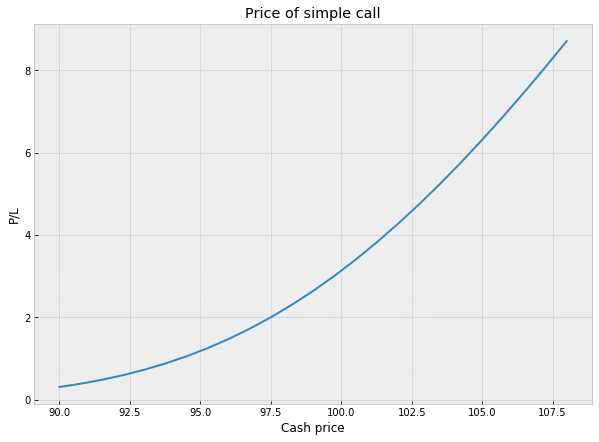

In [51]:
plt.figure(figsize=(10,7))
xs = np.linspace(90, 108, 25)
plt.plot(xs, BS_call(xs, 100, 0, 0.157, 0.25, 0))
plt.title('Price of simple call')
plt.xlabel('Cash price')
plt.ylabel('P/L')
plt.show();

Delta is the tangent to the option price and shows the slope of the price change at the origin (100). Delta is in fact the hedge about the origin and that the hedge would need some adjustment where we see a gap between the slope and the price curve.

An orthodox definition of delta is:

$$Delta = \frac{\partial F}{\partial U} $$

It is the change in the option price coming from infinitely small changes in the underlying asset (useful concept for mathematical derivations).

To make the mathematical continuous time finance delta relevant, it needs to be accompanied by the 2nd derivative (gamma) and at least a third one (DgammaDspot). Because volatility tends to change when markets move, adding vega to the exposure would be necessary.

In the real world, the **modified delta** notion appears to be a more adequate measure:

$$ModifiedDelta = \frac{\Delta F}{\Delta U} $$

with $\Delta$ as the change in option price coming from a set change in the underlying asset. A more powerful tool is:

$$Delta = \frac{1}{2} \Big (\frac{\Delta F}{\Delta U^-} + \frac{\Delta F}{\Delta U^+} \Big)  $$

#### Delta and the probability of being in the money

The delta is the risk-neutral replication of the option.

The value corresponds to the integral of the payoffs between the strike price and infinity for a call (and 0 for a put) assuming the underlying process is risk-neutral. In discrete terms, it would be the sum of the payoff of every eventuality multiplied by its risk-neutral probability. The delta is just the sensitivity of that value to the change in the underlying asset.

Practically speaking, it corresponds to the ratio of the asset the trader must hold to avoid any instantaneous P/L from the micromoves.

The probability of ending in the money is just the discounted probability divorced from the associated payoff. In the study of binary options, it will be shown that delta and the probability of being in the money would be the same at very low vol and in the absence of a skew, and would start diverging in the presence of either a skew or a high vol (causing righ-side skew owing to lognormality).

#### Delta, volatility and extreme volatility

Intuitively, we learn that a rise in vol would cause the delta of an OTM call to rise and that of an ITM call to drop, therefore bringing deltas closer to 50% (of the PV of 50% to be precise).

Asset *S* follows the geometric Brownian motion:

$$S_t = S_0 e^{(\mu - 0.5\sigma^2) + \sigma \sqrt{T}Z} $$

- $\mu$ is the risk neutral drift (i.e. interest rate differential or numeraire rates less carry)
- $\sigma$ is the volatility
- $t$ is time until expiration
- $Z$ follows a reduced centered normal distribution such that $p(z=x) = e^{(\frac{-x^2}{2})/\sqrt{2\pi}}$

We have the conditional expectation:

$$E[S_t]=S_0 exp(\mu t) $$ at time t=0

In [36]:
S_1 = 100 * np.exp((0-0.5*0.10**2) + 0.10*np.sqrt(0.12)*np.random.normal(0,1, 1000))
S_2 = 100 * np.exp((0-0.5*0.157**2) + 0.157*np.sqrt(0.12)*np.random.normal(0,1, 1000))
S_3 = 100 * np.exp((0-0.5*0.50**2) + 0.25*np.sqrt(0.12)*np.random.normal(0,1, 1000))
S_4 = 100 * np.exp((0-0.5*1**2) + 1*np.sqrt(0.12)*np.random.normal(0,1, 1000))

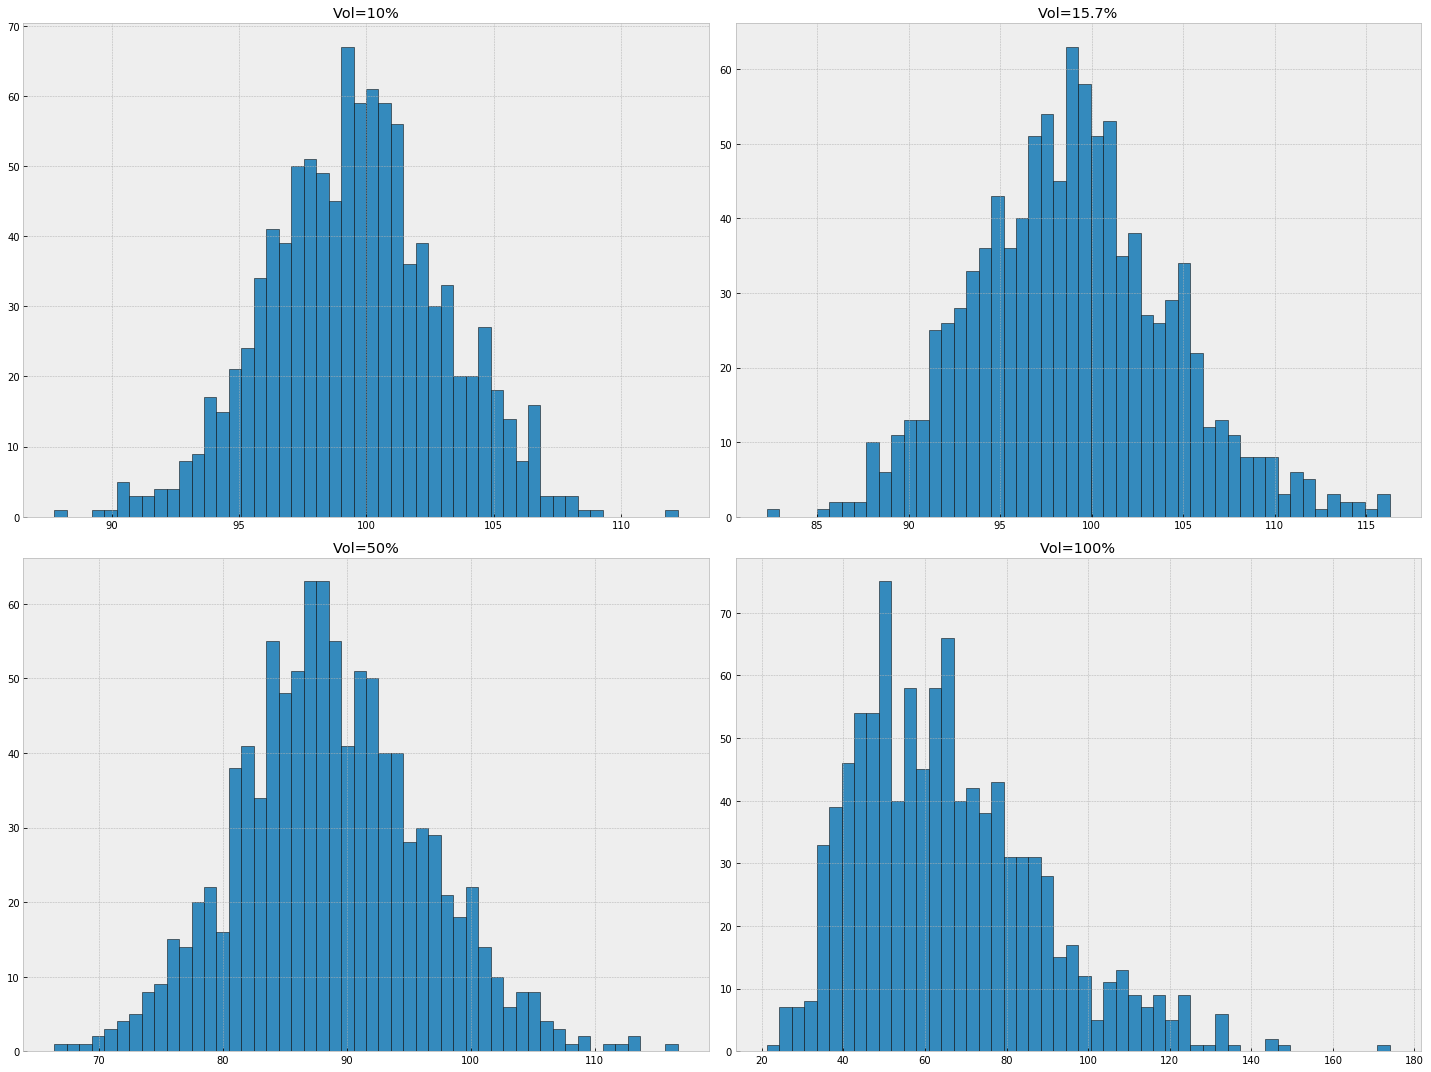

In [37]:
plt.figure(figsize=(20,15))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
ax1.hist(S_1, 50, edgecolor='black')
ax1.title.set_text('Vol=10%')
ax2.hist(S_2, 50, edgecolor='black')
ax2.title.set_text('Vol=15.7%')
ax3.hist(S_3, 50, edgecolor='black')
ax3.title.set_text('Vol=50%')
ax4.hist(S_4, 50, edgecolor='black')
ax4.title.set_text('Vol=100%')
plt.tight_layout()
plt.show();

The rise in volatility has the tendency to increase the expected final price of the asset through compounding while the drift make it decrease by $.5\sigma^2 t$.

The Z values (standard normal scores) share the same probability. The correcting term $-.5\sigma^2t$ satisfies the martingale property: every payoff multiplied by its probability needs to sum up to *S0*.

The compounding is called by the geometric return. Returns compound so a higher volatility would raise such compounding and would increase the divergence between an arithmetic process (where the returns are constant) and a geometric one (the returns depend on the level of the asset). The net effect between these 2 counterbalancing factors is the thickness of the right tails.

We see that at higher volatility, the distribution develops an increasing skew to the right, but the mean remains the same (the surface on each side of 100 are equal). This shift will have an effect on the delta.